# Neurona sense llibreries

Petit experiment que he fet, una neurona només amb sa llibreria numpy, sense torch, tensorflow, scikit, etc

Entrenaré una neurona amb multiples situacions, començare amb un dataset de una porta logica XOR, aquí aniré apuntant resultats:

* XOR: Max aconseguit ha estat 75% de precisió, però per alta probabilitat d'endevinar amb sa primera etapa. Al no ser una classificació lineal, no ho pot representar del tot.
* Vertebrat o Invertebrat: 91% de precisió, al ser una classificació lineal, aconsegueix bons resultats ràpidament, sense gaire necessitat d'ajustar paràmetres.


In [102]:
import numpy as np
import matplotlib.pyplot as plt


## Config

Aquí tenim com un fitxer config amb totes ses variables des projecte

In [103]:
ACTIVATION_FUNCTIONS = {
    'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
    'tanh': lambda x: np.tanh(x),
    'relu': lambda x: np.maximum(0, x)
}

ACTIVATION_DERIVATIVES = {
    'sigmoid': lambda x: x * (1 - x),
    'tanh': lambda x: 1 - np.tanh(x)**2,
    'relu': lambda x: np.where(x > 0, 1, 0)
}

SIGMOID = 'sigmoid'
TANH = 'tanh'
RELU = 'relu'
FUNCTION = TANH

LEARNING_RATE = 0.01

EPOCHS = 300

## Dataset i objectiu

Definició des datasets, XOR i vertebrat/invertebrat.

Ses columnes des dataset XOR són unicament entrades binàries bàsiques de qualsevol sistema.

Ses columnes de vertebrat vs invertebrat són: Num. cames (integer), té exoesquelet(bool), te sang calenta (bool).

In [104]:
# Dataset XOR
dataset_xor = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 0, 1],
    [1, 1, 1, 0],
    [1, 1, 1, 1]
])
objectius_xor = np.array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0])  # Resultats esperats

#Dataset Vertebrat vs invertebrat generat per GPT-o4-mini

dataset = np.array([
    [4, 0, 1],  # Dog
    [4, 0, 1],  # Cat
    [4, 0, 1],  # Horse
    [2, 0, 1],  # Eagle
    [4, 0, 0],  # Frog
    [0, 0, 0],  # Goldfish
    [6, 1, 0],  # Butterfly
    [6, 1, 0],  # Ant
    [8, 1, 0],  # Spider
    [10, 1, 0], # Crab
    [8, 0, 0],  # Octopus
    [0, 0, 0]   # Worm
])

# Codificar y: vertebrate=1, invertebrate=0
objectius = np.array([
    1, 1, 1, 1, 1, 1,  # vertebrates
    0, 0, 0, 0, 0, 0   # invertebrates
])


# Definició classe neurona

### Paràmetres:
* Weights: És un vector de n dimensions, depen de quantes variables conté es dataset per apendre.
* Bias: És s'indicador d'altura de sa regressió lineal.
* inputs: És un vector per a cada fila des dataset.
* Output: És un escalar amb es resultat de s'activació.
* Error: És un float amb s'error total acumulat.

### Mètodes:
* activate(self, inputs, activation_function): Encarregat de realitzar la predicció a partir des inputs i de una funció d'activació a escollir.
* calculate_error(self, target): Encarregat de realitzar un descens de gradient per anar trobant la manera de corregir weights i bias per corregir l'error.
* update_weights(self, learning_rate, derivative): Utilitza l'error calculat per actualitzar self.weights i self.bias.

In [105]:
class Neurona:
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
        self.inputs = None
        self.output = None
        self.error = None


    def activate(self, inputs, activation_function= ACTIVATION_FUNCTIONS[FUNCTION]): 
        # Validar que es inputs tenen sa mateixa dimensió que es weights
        if len(inputs) != len(self.weights):
            raise ValueError(f"Dimensions de inputs ({len(inputs)}) i dimension de weights ({len(self.weights)}) no coincideixen.")
    
        # Guard inputs per despues calcular modificació de weights i biases
        self.inputs = inputs
        # Calcular sa regressió lineal
        z = np.dot(inputs, self.weights) + self.bias
        # Aplicar sa funció d'activació
        self.output = activation_function(z)
        return self.output
    
    def calculate_error(self, target):
        # Resultat esperat li rest obtingut per tenir error
        self.error = target - self.output
        return self.error
    
    def update_weights(self, learning_rate=LEARNING_RATE, derivative= ACTIVATION_DERIVATIVES[FUNCTION]):
        # Calcular gradient segons funció d'activació
        gradient = self.error * derivative(self.output)
        
        # Actualitzar weights i bias
        self.weights += learning_rate * gradient * self.inputs
        self.bias += learning_rate * gradient

    

## Funció d'entrenament

Per a cada dada del dataset i objectiu dins els objectius realitzam ses mateixes funcions, sumant error quadratic per obtenir així un valor absolut i castigant molt més errors grossos ( error = 2 -> 4, error = 0.5 -> 0.25).

Així pes descendent de gradient, una derivada de un quadrat és senzill.


In [106]:
def entrenament(neuron: Neurona, dataset, total_error=0):
    outputs = []
    for data, objectiu in zip(dataset, objectius):
        # Anam stackeant outputs a un array per retornar despúes i poder fer un seguiment
        outputs.append(neuron.activate(data))
        # Calculam s'error a cada ouput
        error = neuron.calculate_error(objectiu)
        # Acumulam error quadràtic
        total_error += error**2
        # Actualizam es valors de sa regressió lineal
        neuron.update_weights()
    return outputs, total_error


## Funció main

Aquí replegam es resultats de s'entrenament i monitorejam com ha anat cada etapa.

Es pesos els estic reduint ja que és millor començar amb un valor reduit.

In [107]:
def main():
    # Primer inicialitzam neurona amb pesos aleatoris
    weights = np.random.randn(3) * 0.1
    bias = np.random.randn()
    neurona = Neurona(weights, bias)

    '''Començam a entrenar'''
    i = 0
    errors = []      # Llista per guardar errors
    accuracies = []  # Llista per guardar accuracies

    best_accuracy = 0 
    patience = 100
    no_improvement = 0
    last_improvement = 0  

    while i < EPOCHS:
        outputs, error = entrenament(neurona, dataset)
        predictions = [1 if o >= 0.5 else 0 for o in outputs]
        accuracy = sum(1 for p, t in zip(predictions, objectius) if p == t) / len(objectius)
        
        errors.append(error)
        accuracies.append(accuracy)
        
        # Comprovam millora només en accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            last_improvement = i
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Aturat a epoch: {i} per falta de canvis")
            print(f"Millor accuracy: {best_accuracy:.2%}")
            print(f"Ultima millora ha estat a epoch: {last_improvement}")
            break
            
        if i % 50 == 0:
            print(f"Epoch {i}: Error = {error:.4f}, Accuracy = {accuracy:.2%}")
        
        i += 1
    
    # Cream la gràfica
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(errors, 'r-', label='Error')
    plt.title('Error vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, 'b-', label='Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return neurona, errors[-1], accuracies[-1]

Epoch 0: Error = 2.8420, Accuracy = 58.33%
Epoch 50: Error = 1.2475, Accuracy = 91.67%
Epoch 100: Error = 1.1390, Accuracy = 91.67%
Aturat a epoch: 111 per falta de canvis
Millor accuracy: 91.67%
Ultima millora ha estat a epoch: 11


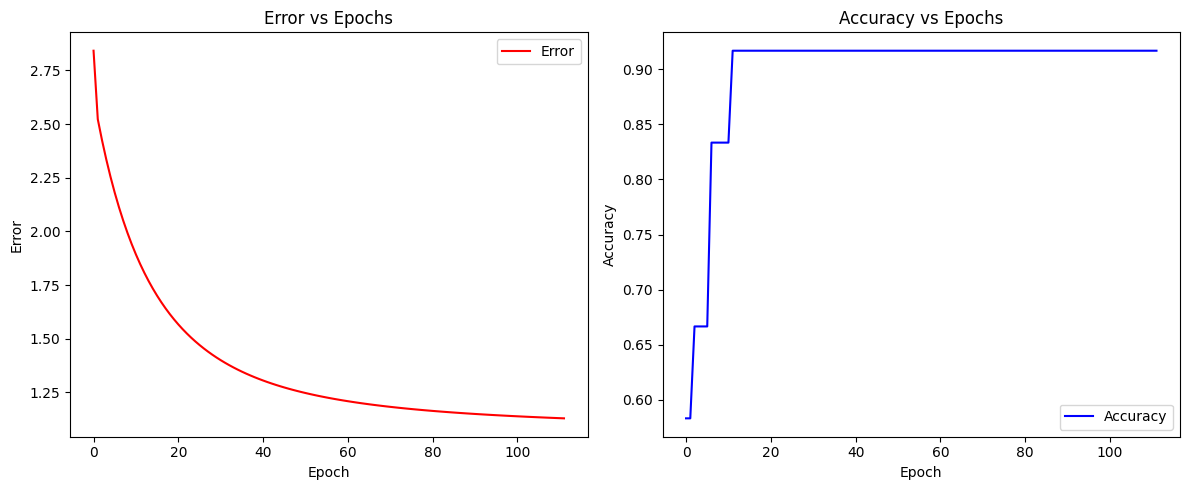

(<__main__.Neurona object at 0x0000021F323A2930>, np.float64(1.1294676322499837), 0.9166666666666666)


In [114]:
print(main())